In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
dataset = pd.read_csv(r"C:\Users\hp\Desktop\Tech Mango\Datasets\Fake_or_Real.csv", encoding='ISO-8859-1')


In [3]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   News_Headline  9960 non-null   object
 1   Link_Of_News   9960 non-null   object
 2   Source         9960 non-null   object
 3   Stated_On      9960 non-null   object
 4   Date           9960 non-null   object
 5   Label          9960 non-null   object
dtypes: object(6)
memory usage: 467.0+ KB


Text(0.5, 1.0, 'NO OF FAKE AND REAL')

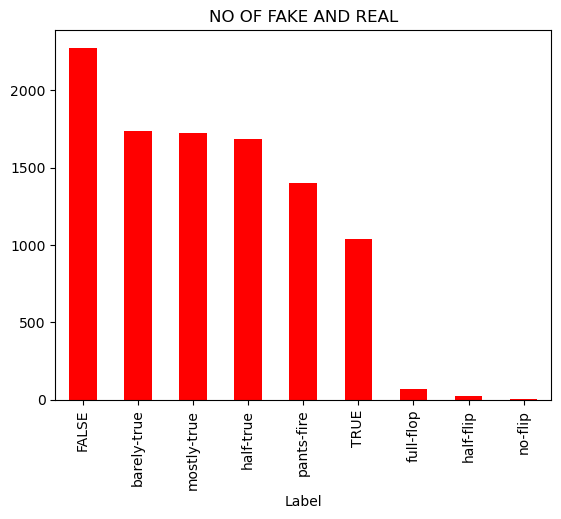

In [5]:
dataset['Label'].value_counts().plot.bar(color='red')
plt.title("NO OF FAKE AND REAL")

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
Fake_news = dataset[dataset['Label'] == "FALSE"]
Real_news = dataset[dataset['Label'] == "TRUE"]

In [8]:
fake_spaceydocs = list(nlp.pipe(Fake_news['Source']))
real_spaceydocs = list(nlp.pipe(Real_news['Source'])) 

In [9]:
def extract_token(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [10]:
fake_tags = []
columns = ["token", "Ner_tag", "Pos_tag"]

In [11]:
for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tags.append(tags)
fake_tags = pd.concat(fake_tags)

In [12]:
real_tags = []
columns = ["token", "Ner_tag", "Pos_tag"]

In [13]:
for ix, doc in enumerate(real_spaceydocs):
    tags = extract_token(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    real_tags.append(tags)

In [14]:
real_tags = pd.concat(real_tags)

In [15]:
fake_tags.head()

,token,Ner_tag,Pos_tag
0,Donald,PERSON,PROPN
1,Trump,PERSON,PROPN
2,Jr.,PERSON,PROPN
0,Facebook,,NOUN
1,posts,,NOUN


In [16]:
pos_count_fake = fake_tags.groupby(['token','Pos_tag']).size().reset_index(name="counts") 
pos_count_fake.head()

,token,Pos_tag,counts
0,"""",PUNCT,2
1,%,NOUN,1
2,&,CCONJ,1
3,",",PUNCT,4
4,-,PROPN,1


In [17]:
pos_count_real = real_tags.groupby(['token','Pos_tag']).size().reset_index(name="counts") 
pos_count_real.head()

,token,Pos_tag,counts
0,"""",PUNCT,4
1,&,CCONJ,2
2,'s,PART,3
3,",",PUNCT,1
4,-,ADJ,1


In [18]:
pos_count_fake.groupby('Pos_tag')['token'].count().head()

Pos_tag
ADJ      12
ADP       6
ADV       4
AUX       2
CCONJ     3
Name: token, dtype: int64

In [19]:
pos_count_real.groupby('Pos_tag')['token'].count().head()

Pos_tag
ADJ      4
ADP      5
ADV      2
AUX      1
CCONJ    2
Name: token, dtype: int64

In [20]:
top_fake = fake_tags[fake_tags['Ner_tag'] != ""].groupby(['token','Ner_tag']).size().reset_index(name='counts')

In [21]:
top_real = real_tags[real_tags['Ner_tag'] != ""].groupby(['token','Ner_tag']).size().reset_index(name='counts')

In [22]:
import seaborn as sns

In [23]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

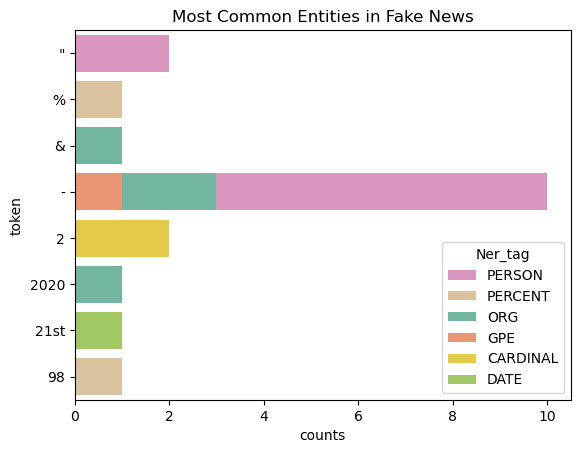

In [24]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'Ner_tag',
    palette = ner_palette,
    data = top_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Real News')]

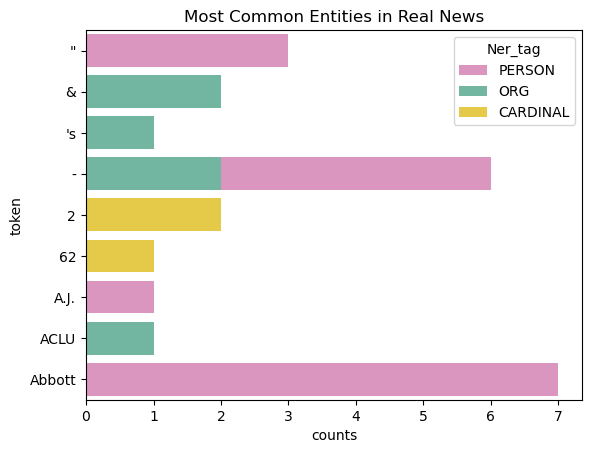

In [25]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'Ner_tag',
    palette = ner_palette,
    data = top_real[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Real News')

In [26]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE


In [27]:
dataset['News_headline'] = dataset['News_Headline'].apply(lambda X: re.sub("[^\w\s]","",str(X)))

In [28]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...


In [29]:
dataset['News_Lower'] = dataset['News_headline'].str.lower()

In [30]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...


In [31]:
en_stopwords = stopwords.words('english')
en_stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [32]:
dataset['Text_Clean'] = dataset['News_Lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [33]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower,Text_Clean
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden,says osama bin laden endorsed joe biden
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...,cnn aired video toddler running away another t...
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...,says tim tebow kneeled protest abortion nation...
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...,even socalled moderate democrats like joe bide...
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...,health department city county declared racism ...


In [34]:
dataset['Tokenize'] = dataset['Text_Clean'].apply(word_tokenize)

In [35]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower,Text_Clean,Tokenize
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden,says osama bin laden endorsed joe biden,"[says, osama, bin, laden, endorsed, joe, biden]"
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...,cnn aired video toddler running away another t...,"[cnn, aired, video, toddler, running, away, an..."
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...,says tim tebow kneeled protest abortion nation...,"[says, tim, tebow, kneeled, protest, abortion,..."
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...,even socalled moderate democrats like joe bide...,"[even, socalled, moderate, democrats, like, jo..."
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...,health department city county declared racism ...,"[health, department, city, county, declared, r..."


In [36]:
lemmatizer = WordNetLemmatizer()

In [37]:
dataset['Lemmatizer'] = dataset['Tokenize'].apply(lambda X : [lemmatizer.lemmatize(token) for token in X])


In [38]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower,Text_Clean,Tokenize,Lemmatizer
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden,says osama bin laden endorsed joe biden,"[says, osama, bin, laden, endorsed, joe, biden]","[say, osama, bin, laden, endorsed, joe, biden]"
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...,cnn aired video toddler running away another t...,"[cnn, aired, video, toddler, running, away, an...","[cnn, aired, video, toddler, running, away, an..."
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...,says tim tebow kneeled protest abortion nation...,"[says, tim, tebow, kneeled, protest, abortion,...","[say, tim, tebow, kneeled, protest, abortion, ..."
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...,even socalled moderate democrats like joe bide...,"[even, socalled, moderate, democrats, like, jo...","[even, socalled, moderate, democrat, like, joe..."
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...,health department city county declared racism ...,"[health, department, city, county, declared, r...","[health, department, city, county, declared, r..."


In [39]:
dataset['Lemmatizer'][0]

['say', 'osama', 'bin', 'laden', 'endorsed', 'joe', 'biden']

In [40]:
Token_clean = sum(dataset['Tokenize'],[])

In [41]:
unigrams = (pd.Series(nltk.ngrams(Token_clean,1)).value_counts()).reset_index()

In [42]:
unigrams[:10]

,index,count
0,"(says,)",2652
1,"(percent,)",844
2,"(people,)",762
3,"(trump,)",648
4,"(president,)",601
5,"(state,)",585
6,"(years,)",513
7,"(us,)",497
8,"(states,)",494
9,"(tax,)",488


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

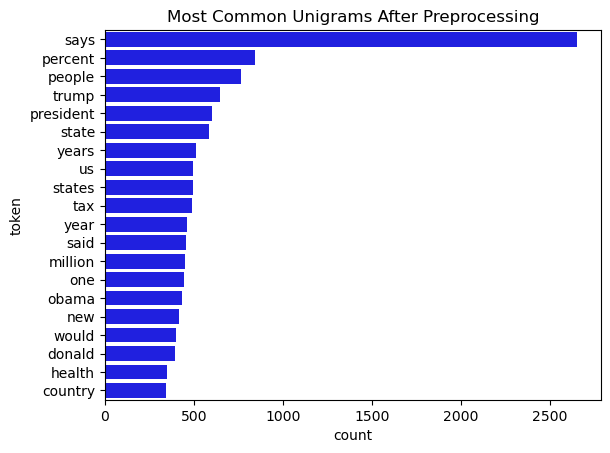

In [43]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])
sns.barplot(x = "count", 
            y = "token", 
            data=unigrams[:20],
            orient = 'h',
            color = 'blue', legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

Sentiment - Analysis

In [44]:
vader_sentiment = SentimentIntensityAnalyzer()

In [45]:
dataset['Sentiment_Score'] = dataset['Text_Clean'].apply(lambda X: vader_sentiment.polarity_scores(X)['compound'])

In [46]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower,Text_Clean,Tokenize,Lemmatizer,Sentiment_Score
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden,says osama bin laden endorsed joe biden,"[says, osama, bin, laden, endorsed, joe, biden]","[say, osama, bin, laden, endorsed, joe, biden]",0.2500
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...,cnn aired video toddler running away another t...,"[cnn, aired, video, toddler, running, away, an...","[cnn, aired, video, toddler, running, away, an...",-0.9186
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...,says tim tebow kneeled protest abortion nation...,"[says, tim, tebow, kneeled, protest, abortion,...","[say, tim, tebow, kneeled, protest, abortion, ...",0.2960
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...,even socalled moderate democrats like joe bide...,"[even, socalled, moderate, democrats, like, jo...","[even, socalled, moderate, democrat, like, joe...",-0.4939
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...,health department city county declared racism ...,"[health, department, city, county, declared, r...","[health, department, city, county, declared, r...",-0.8481


In [50]:
bins = [-1,-0.1,0.1,1]

In [51]:
names = ['negative','neutral','positive']

In [53]:
dataset['Sentiment_Label'] = pd.cut(dataset['Sentiment_Score'],bins,labels=names)

In [54]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower,Text_Clean,Tokenize,Lemmatizer,Sentiment_Score,Sentiment_Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden,says osama bin laden endorsed joe biden,"[says, osama, bin, laden, endorsed, joe, biden]","[say, osama, bin, laden, endorsed, joe, biden]",0.2500,positive
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...,cnn aired video toddler running away another t...,"[cnn, aired, video, toddler, running, away, an...","[cnn, aired, video, toddler, running, away, an...",-0.9186,negative
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...,says tim tebow kneeled protest abortion nation...,"[says, tim, tebow, kneeled, protest, abortion,...","[say, tim, tebow, kneeled, protest, abortion, ...",0.2960,positive
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...,even socalled moderate democrats like joe bide...,"[even, socalled, moderate, democrats, like, jo...","[even, socalled, moderate, democrat, like, joe...",-0.4939,negative
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...,health department city county declared racism ...,"[health, department, city, county, declared, r...","[health, department, city, county, declared, r...",-0.8481,negative


<Axes: xlabel='Sentiment_Label'>

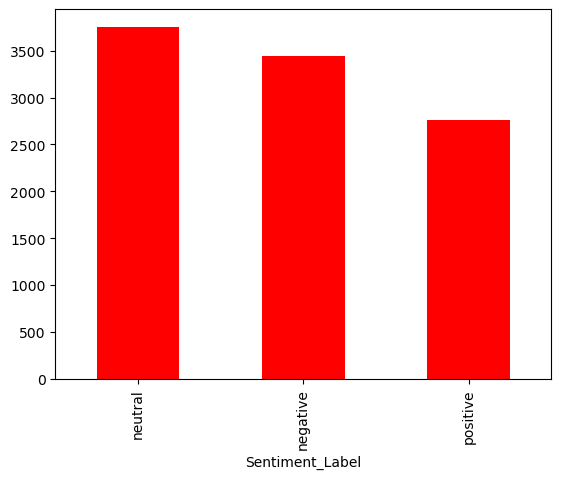

In [57]:
dataset['Sentiment_Label'].value_counts().plot.bar(color= 'red')

C:\Users\hp\AppData\Local\Temp\ipykernel_10840\134361374.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

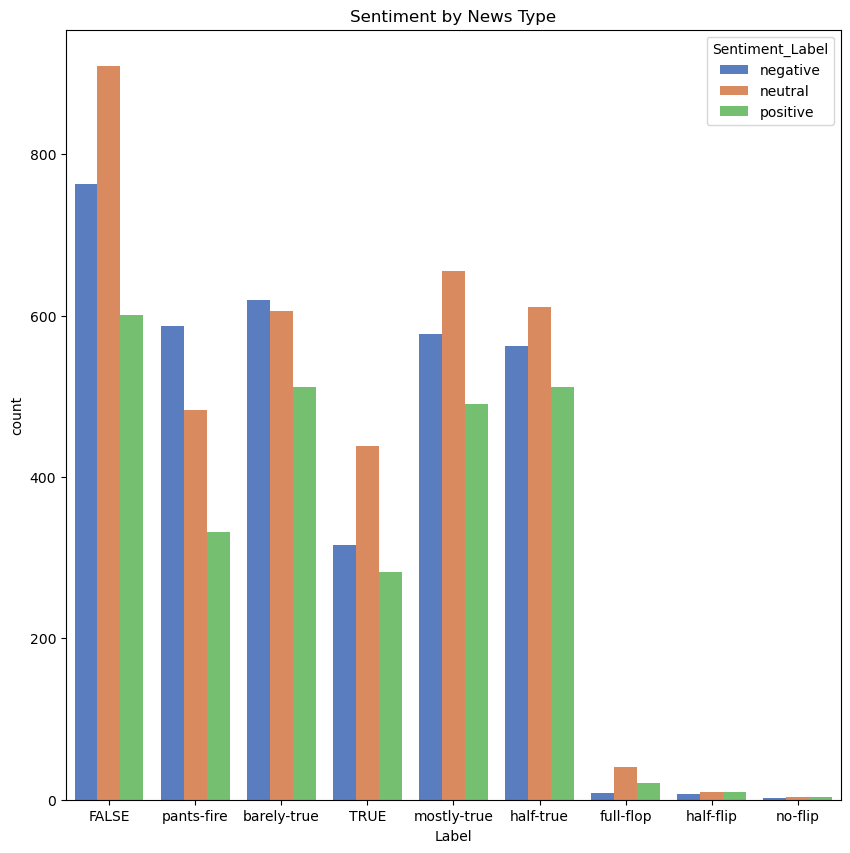

In [68]:
plt.figure(figsize=(10, 10))
sns.countplot(
    x = 'Label',
    hue = 'Sentiment_Label',
    #palette=sns.color_palette("colorblind")
    #palette=sns.color_palette("Set1") 
    palette=sns.color_palette("muted"),
    data = dataset
) \
.set(title='Sentiment by News Type')

CLassification_Model

In [70]:
dataset.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,News_headline,News_Lower,Text_Clean,Tokenize,Lemmatizer,Sentiment_Score,Sentiment_Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,Says Osama bin Laden endorsed Joe Biden,says osama bin laden endorsed joe biden,says osama bin laden endorsed joe biden,"[says, osama, bin, laden, endorsed, joe, biden]","[say, osama, bin, laden, endorsed, joe, biden]",0.2500,positive
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,CNN aired a video of a toddler running away fr...,cnn aired a video of a toddler running away fr...,cnn aired video toddler running away another t...,"[cnn, aired, video, toddler, running, away, an...","[cnn, aired, video, toddler, running, away, an...",-0.9186,negative
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,Says Tim Tebow kneeled in protest of abortion ...,says tim tebow kneeled in protest of abortion ...,says tim tebow kneeled protest abortion nation...,"[says, tim, tebow, kneeled, protest, abortion,...","[say, tim, tebow, kneeled, protest, abortion, ...",0.2960,positive
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true,Even socalled moderate Democrats like Joe Bide...,even socalled moderate democrats like joe bide...,even socalled moderate democrats like joe bide...,"[even, socalled, moderate, democrats, like, jo...","[even, socalled, moderate, democrat, like, joe...",-0.4939,negative
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,Our health department our city and our county ...,our health department our city and our county ...,health department city county declared racism ...,"[health, department, city, county, declared, r...","[health, department, city, county, declared, r...",-0.8481,negative


In [81]:
x = dataset['Text_Clean']
y = dataset['Label']

In [82]:
countvec = CountVectorizer()

In [84]:
countvec_fit = countvec.fit_transform(x) 

In [89]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(),columns=countvec.get_feature_names_out())

In [91]:
bag_of_words

,003,005,01,02,04,045,047,06,060220,08,...,zones,zoning,zoo,zoom,zuber,zucker,zuckerberg,zuckerbergs,zyphr,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,y,test_size=0.3,random_state=7) 

In [96]:
lr = LogisticRegression(random_state=0).fit(x_train,y_train)

In [97]:
y_pred = lr.predict(x_test)

In [100]:
accuracy = accuracy_score(y_pred,y_test)

In [101]:
accuracy

0.26874163319946454

In [103]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       FALSE       0.39      0.30      0.34       863
        TRUE       0.13      0.22      0.17       202
 barely-true       0.22      0.21      0.21       526
   full-flop       0.06      0.50      0.11         2
   half-flip       0.20      1.00      0.33         1
   half-true       0.22      0.21      0.21       504
 mostly-true       0.26      0.26      0.26       507
     no-flip       0.00      0.00      0.00         0
  pants-fire       0.33      0.37      0.35       383

    accuracy                           0.27      2988
   macro avg       0.20      0.34      0.22      2988
weighted avg       0.28      0.27      0.27      2988



C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
svm = SGDClassifier().fit(x_train,y_train)

In [107]:
y_pred_svm = svm.predict(x_test)

In [109]:
accuracy_score(y_pred_svm,y_test)

0.24799196787148595

In [110]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

       FALSE       0.30      0.30      0.30       666
        TRUE       0.19      0.23      0.21       342
 barely-true       0.22      0.22      0.22       516
   full-flop       0.20      0.18      0.19        17
   half-flip       0.20      0.20      0.20         5
   half-true       0.20      0.19      0.19       486
 mostly-true       0.24      0.22      0.23       521
     no-flip       0.00      0.00      0.00         2
  pants-fire       0.33      0.31      0.32       433

    accuracy                           0.25      2988
   macro avg       0.21      0.21      0.21      2988
weighted avg       0.25      0.25      0.25      2988

